<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/lab/lab10/lab10-pytorch-cnn-skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab 10 : Rețele Convoluționale în PyTorch
===================================

### Clasificare supervizată folosind arhitectura ResNet-50

Exemple introduse în acest laborator:
- preprocesarea datelor în PyTorch ([data transforms](https://pytorch.org/docs/stable/torchvision/transforms.html))
- utilizarea unui [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
- definirea unei arhitecturi convoluționale în PyTorch
- efectul utilizării normalizării la nivel de batch (batch normalization - [Descriere](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c), [Modul PyTorch](https://pytorch.org/docs/stable/nn.html#batchnorm2d)) în arhitecturi convoluționale adânci
- ciclul de antrenare al unei rețele în PyTorch


**Credit**:
- Exercitii și structură cod adaptate din tutorialul ConvNet al Vioricăi Pătrăucean, din cadrul EEML 2019.
- Arhitectura ResNet-50 din PyTorch model zoo

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import torch
import torch.nn as nn

# Definirea mediului pe care va rula codul de antrenare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum
import warnings
warnings.filterwarnings('ignore')

Running code @ cuda


## Descărcare și preparare date

* **Cifar-10** este echivalentul MNIST pentru imagini naturale RGB

* cuprinde 60k 32x32 imagini color din 10 clase: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

* train: 50k; test: 10k


**Exemplu 1: Implementarea unor metode de augmentare de date**

În Pytorch pot fi folosite _transformări de date_ la momentul încărcării în memorie a unui set de date. 
Pentru aceasta se pot utiliza clase predefinite (din pachetul `torchvision.transforms`) sau pot fi construite clase custom.

În acest exemplu folosim _transforms_ pentru a aplica două tehnici de **augmentare a datelor**, folosite la antrenare: oglindiri aleatoare a imaginilor și crop-uri aleatoare ale imaginii (sunt folosite clase existente în pachetul `torchvision.transforms`.


In [2]:
# Prepare data 
import torchvision
import torchvision.transforms as transforms

NUM_WORKERS = 2


TRAIN_DATASET_SIZE = 50000
TEST_DATASET_SIZE = 10000

CIFAR10_IMG_WIDTH = 32
CIFAR10_IMG_HEIGHT = 32

DATA_MEAN = (0.5, 0.5, 0.5)    # define the mean for the scaling transform - PIL images already come given in 
DATA_STD = (0.5, 0.5, 0.5)        # define the standard deviation for the scaling transform
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),     # apply random horizontal flip
        transforms.RandomCrop(                          # apply random crop, after padding image with 4 values on each side, using `reflect` mode
            size=(CIFAR10_IMG_WIDTH, CIFAR10_IMG_HEIGHT), 
            padding=(4, 4), 
            padding_mode="reflect"),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD)       # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
    ] 
)


test_transform = transforms.Compose(
    [
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD) 
    ] 
)



train_images = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                            transform=train_transform)

test_images = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, 
                                           transform=test_transform)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')

Files already downloaded and verified
Files already downloaded and verified
Size of training images (50000, 32, 32, 3)
Size of training labels 50000
Size of test images (10000, 32, 32, 3)
Size of test labels 10000


## Afișare imagini
Implementarea unei „galerii” de imagini pentru vizualizarea setului de date.

In [3]:
MAX_IMAGES = 10

def gallery(images, label, title='Input images'):
    class_dict = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_frames, h, w, num_channels = images.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames, figsize=(num_frames, 1), subplot_kw={'xticks': [], 
                                                                                'yticks': []})
    for i in range(0, num_frames):
        if num_channels == 3:
            axes[i].imshow(np.squeeze(images[i]))
        else:
            axes[i].imshow(np.squeeze(images[i]), cmap='gray')
        axes[i].set_title(class_dict[label[i]])
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
    ff.subplots_adjust(wspace=0.1)
    plt.show()

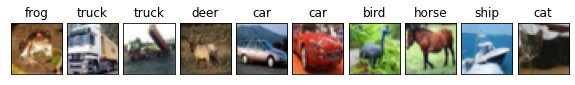

In [4]:
gallery(train_images.data, train_images.targets)

## Pregătirea datelor pentru antrenare și testare
* pentru antrenare folosim optimizatori stocastici (e.g. SGD, Adam), asa că trebuie sa putem eșantiona exemple aleatoare din setul de date pentru a forma mini-batch-uri
* pentru testare iterăm în mod secvențial prin setul de date

In [5]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 100  #@param
BATCH_SIZE_TEST = 100  #@param
NO_WORKERS = 8  #@param
SHUFFLE_DATA = True

# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')


Shape of training images: torch.Size([100, 3, 32, 32])
Shape of training labels: torch.Size([100])


In [6]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')


Shape of test images: torch.Size([100, 3, 32, 32])
Shape of test labels: torch.Size([100])


### Setări generale: nume model, utilizare batch normalization, utilizare regularizare

In [7]:
model = "resnet_v2" 
flag_batch_norm = 'OFF'  # @param['ON', 'OFF']
flag_regularize = True     # @param['True', 'False'] {type:"raw"}

## 1. Definirea arhitecturii RESNET-50 - blocuri funcționale

Implementarea propusă în PyTorch pentru ResNet-50 definește 4 straturi logice de grupuri _ResNet blocks_. Ele sunt definite în funcție de numărul de canale ce rezultă din fiecare strat logic.

Astfel, rețeaua este compusă din urmatoarele blocuri funcționale:
  * 3 blocuri ResNet cu 64 canale și  _"first-block-dimension-reduction-stride"_ = 1
  * 4 blocuri ResNet cu 128 canale și _"first-block-dimension-reduction-stride"_ = 2 (i.e. îmjumătățim dimensiunea inputului)
  * 6 blocuri ResNet cu 256 canale și _"first-block-dimension-reduction-stride"_ = 2 (i.e. îmjumătățim dimensiunea inputului)
  * 3 blocuri ResNet cu 512 canale și _"first-block-dimension-reduction-stride"_ = 2 (i.e. îmjumătățim dimensiunea inputului)

**Observație**: Pentru ca rețeaua ResNet are mulți parametrii, este posibil ca antrenarea ei să dureze mult pe resurse CPU sau chiar Colab.
Pentru a înlesni antrenarea, utilizăm un factor de reducere a numărului de canale (`DOWNSIZE_FACTOR`) care împarte numărul de canale rezultant după fiecare strat logic (e.g. 64/4, 128/4, 256/4, 512/4) 

In [8]:
# define parameters of resnet blocks for resnet-50 model
import collections

ResNetBlockParams = collections.namedtuple(
    "ResNetBlockParams", ["neck_ch", "blocks", "stride"])

DOWNSIZE_FACTOR = 1     # @param[8, 4, 2, 1]

BLOCKS_50 = (
    ResNetBlockParams(int(64/DOWNSIZE_FACTOR), 3, 1),
    ResNetBlockParams(int(128/DOWNSIZE_FACTOR), 4, 2),
    ResNetBlockParams(int(256/DOWNSIZE_FACTOR), 6, 2),
    ResNetBlockParams(int(512/DOWNSIZE_FACTOR), 3, 2)
)

### TODO 1: definiți apelurile de convoluții 3x3 și 1x1 folosite într-un bloc ResNet-50 
Instantiați în mod corespunzător clasa de tip [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html) din PyTorch 

In [9]:
def conv3x3(in_planes, out_planes, stride=1, padding=1, bias = False):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps 
    
    """
    # TODO 1.1 return nn.Conv2d(...)
    return nn.Conv2d(in_planes, out_planes, 3, stride=stride, padding=padding, bias=bias)


def conv1x1(in_planes, out_planes, stride=1, bias=False):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    # TODO 1.2 return nn.Conv2d(...)
    return nn.Conv2d(in_planes, out_planes, 1, stride=stride, bias=bias)

### TODO 2: definiți blocuri ResNet cu "gâtuire" (bottleneck)

Blocul de tip "bottleneck" din ResNet-50 este definit ca în figura următoare.

![ResNet-50 Bottleneck block](https://github.com/asorici/NN-labs/blob/master/Lab3-CNN/img/Bottleneck-Blocks-for-ResNet-50-left-identity-shortcut-right-projection-shortcut.png?raw=1)

În imaginea din stânga se observă cazul cu `stride=1`, unde blocul nu face o reducere a dimensiunii ( _downsampling_ ) pentru că operația de conv 3x3 efectuată pe partea residuală pastrează dimensiunile (folosind stride=1)

Imaginea din dreapta arată operațiile efectuate atunci când `stride=2` și unde ieșirea stratului de gâtuire necesită o operație de _downsampling_ pentru a duce dimensiunea inputului la una egală cu cea înjumătățită care are loc pe calea reziduală.


In [10]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 base_width=int(64/DOWNSIZE_FACTOR), norm_layer=nn.BatchNorm2d):
        """
        :param inplanes: initial number of input channels for the bottleneck block
        :param planes: number of output channels  at the end of the ResNet block
        :base_width: the number of channels at the start of the first logical ResNet-50 layer - the default is 64/DOWNSIZE_FACTOR
                                  used to derive the channel size `f` of this bottleneck block
        :downsample: a 1x1 conv layer that downsamples the input size or `None` if no downsampling needs to be performed 
        :norm_layer: the type of normalization to apply at after each conv operation, default is nn.BatchNorm2d
        """
        super(Bottleneck, self).__init__()
        
        # `inplanes` defines the initial number of input channels for the bottleneck block
        # `width` encodes the number of filters `f` in the picture of the bottleneck block above 
        width = int(planes * (base_width / (64./DOWNSIZE_FACTOR)))
        
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        
        # BEGIN TODO 2.1
        
        # first conv 1x1 layer which implements the bottlenecking
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        
        # conv 3x3 layer which applies the stride given as parameter
        self.conv2 = conv3x3(width, width, stride)
        self.bn2 = norm_layer(width)
        
        # conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # according to the above figure, the expansion factor is set to 4
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        
        # END TODO 2.2

        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        
        # TODO 2.2
        # first layer conv1 + bn1 + relu
        out = nn.Sequential(self.conv1, self.bn1, self.relu)(x)
        
        # second layer conv2 + bn2 + relu
        out = nn.Sequential(self.conv2, self.bn2, self.relu)(out)

        # third layer conv3 + bn3
        out = nn.Sequential(self.conv3, self.bn3)(out)

        # apply downsample to identity (original input to block), if it is defined (right image in figure above)
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # add identity to residual and apply relu
        out += identity
        out = self.relu(out)

        return out

## 2. Definirea arhitecturii ResNet-50 - compunerea blocurilor funcționale
<div>
	<img title="ResNet-50 Architecture" src="https://github.com/asorici/NN-labs/blob/master/Lab3-CNN/img/ResNet-50-arch.jpg?raw=1" width="300"/>
</div>


In [11]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, base_width=int(64/DOWNSIZE_FACTOR), 
                 norm_layer=nn.BatchNorm2d):
        """
        Build the ResNet network model - based on PyTorch Model Zoo implementation
        
        :param block: the Resnet Block model to be used: in our case the `Bottleneck` block
        :param layers: the logical layer definition, such as the one in BLOCKS_50
        :param num_classes: the number of classes for target labels
        :param base_width: the initial number of layers
        :param norm_layer: the type of normalization to apply - either BatchNorm or EmptyNorm, default is BatchNorm
        """
        super(ResNet, self).__init__()

        self.inplanes = int(64/DOWNSIZE_FACTOR)
        self.dilation = 1
        self._norm_layer = norm_layer
        
        self.base_width = base_width
        
        # ResNet starts out with an initial 7x7 convolution with stride 2 that halves the input size
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        
        # We skip the maxpool layer because it would reduce the size too much starting from a 32 x 32 image 
        # self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=1)
        
        # -- Build resnet logical layers
        l = layers
        
        # logical layer1 - 3 bottleneck blocks with 64 filters and stride=1 
        self.layer1 = self._make_layer(block, l[0].neck_ch, l[0].blocks, stride=l[0].stride)    # image is 16x16
        
        # logical layer2 - 4 bottleneck blocks with 128 filters and stride=2  (i.e. first halving)
        self.layer2 = self._make_layer(block, l[1].neck_ch, l[1].blocks, stride=l[1].stride)    # image is 8x8
        
        # logical layer3 - 6 bottleneck blocks with 256 filters and stride=2  (i.e. second halving)
        self.layer3 = self._make_layer(block, l[2].neck_ch, l[2].blocks, stride=l[2].stride)    # image is 4x4
        
        # logical layer4 - 3 bottleneck blocks with 512 filters and stride=2  (i.e. third halving)
        self.layer4 = self._make_layer(block, l[3].neck_ch, l[3].blocks, stride=l[3].stride)    # image is 2x2
        
        # final ResNet layers - average pooling reduces size to 1x1 + fully connected layer of size 2048
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(int(512/DOWNSIZE_FACTOR) * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = list()
        
        # first Bottleneck block in the logical layer is the one that does the downsampling 
        layers.append(block(self.inplanes, planes, 
                            stride=stride, downsample=downsample,
                            base_width=self.base_width, 
                            norm_layer=norm_layer))
        
        # the rest operate on the the downsampled result, keeping the size (i.e. using default stride of 1)
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                base_width=self.base_width,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [12]:
from torchvision.models.resnet import model_urls
from torch.utils.model_zoo import load_url as load_state_dict_from_url

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, BLOCKS_50, pretrained, progress,
                   **kwargs)


### Definirea unui strat de normalizare de tip identitate
Inputul este forwardat ca atare.

In [13]:
class EmptyNorm(nn.Module):
    def __init__(self, *args, **kwargs):
        super(EmptyNorm, self).__init__()
        self._modules = dict()
    
    def forward(self, input):
        return input

## 3. Pregătirea pipeline-ului de antrenare

### Parametrizarea preprocesării datelor

In [14]:
# First define the preprocessing ops for the train/test data
crop_height = 32  # @param 
crop_width = 32  # @param
NUM_CLASSES = 10  # @param

### Initializarea modelului rețelei și funcții auxiliare pentru inspectarea modelului definit

In [15]:
blocks = BLOCKS_50     # arhitectura blocurilor functionale

net = None                       # type: nn.Module

if flag_batch_norm == "ON":
    net = resnet50(num_classes=NUM_CLASSES)
else:
    net = resnet50(num_classes=NUM_CLASSES, norm_layer=EmptyNorm)
    
net.train()                         # Default after init is train
net = net.to(device)      # Move network to device

print(list(net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): EmptyNorm()
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): EmptyNorm()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): EmptyNorm()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): EmptyNorm()
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): EmptyNorm()
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): EmptyNorm()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): EmptyNorm()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [16]:
# Get number of parameters in a model by iterating through the model parameters
def get_num_params(model):
    num_params = 0
    for params in model.parameters():
        num_params += params.shape.numel()
        
    return num_params

In [17]:
# Get number of parameters in the model. Verify that we have implemented models correctly
print("Total number of parameters of models")
print(str(net.__class__), ": ", get_num_params(net))  

# should be on the order of 23M for default ResNet
# if scaled down by 4: 1.4M for ResNet

Total number of parameters of models
<class '__main__.ResNet'> :  23475402


In [18]:
def top_k_accuracy(k, target, output):
    batch_size = target.size(0)
    
    _, pred = output.topk(k, 1, True, True)
    
    pred = pred.t()
    correct = pred.eq(target.to(device).view(1, -1).expand_as(pred))

    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    correct_k.mul_(100.0 / batch_size)
    
    return correct_k

### Parametrizarea optimizatorului

In [19]:
lr_init = 0.01                # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-4  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [90e3, 100e3, 110e3]

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
#optimizer = torch.optim.SGD(net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

if flag_regularize:
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=weight_decay_factor)
        
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

### Afișarea loss-ului

In [20]:
# Function that takes a list of losses and plots them.
REFRESH_EVERY = 1000

def plot_losses(loss_list, steps, ct):
    if ct % REFRESH_EVERY == 0:
        display.clear_output(wait=True)
    
    display.display(pl.gcf())
    pl.plot(steps, loss_list, c='b')
    time.sleep(1.0)

### Parametrizarea iterațiilor de antrenare, raportare și testare

In [21]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 100e3  # @param
REPORT_TRAIN_EVERY = 100  # @param
PLOT_EVERY = 100  # @param
REPORT_TEST_EVERY = 200  # @param
TEST_ITERS = 100  # @param

## 4. Antrenarea modelului

In [ ]:
# Question: What is the accuracy of the model at iteration 0, i.e. before training starts?

# EPOCHS = int(TRAIN_ITERS / (TRAIN_DATASET_SIZE / BATCH_SIZE_TRAIN))
EPOCHS = 50

train_iter = 0
losses = []
steps = []

# simulate an inifinte test data provider by looping over the test data
test_data_provider = loopy_test_loader(test_loader)

# set model in train mode
net.train()

running_loss = 0.0
running_acc = 0.0
ct = 0

for epoch in range(int(EPOCHS)):  # loop over the dataset multiple times
    
    for i, data in enumerate(train_loader, 0):
        # set the learning rate and decay according to iteration schedule
        lr_scheduler.step()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += top_k_accuracy(1, labels, outputs)
        
        if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
            train_loss = running_loss / REPORT_TRAIN_EVERY
            train_acc = running_acc / REPORT_TRAIN_EVERY
            
            print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
            print('[%d, %5d] loss: %.5f, acc: %.5f' %
                  (epoch + 1, i + 1, train_loss, train_acc))
            
            losses.append(train_loss)
            steps.append(train_iter)
            
            running_loss = 0
            train_loss = 0
            running_acc = 0
            train_acc = 0
            
            
        if train_iter % PLOT_EVERY == 0:
            plot_losses(losses, steps, train_iter)
            
        train_iter += 1
    
        if train_iter % REPORT_TEST_EVERY == 0:
            # set model in test mode
            net.eval()
            
            with torch.no_grad():
                # evaluate over at most TEST_ITER sub samples from the test_loader
                test_iter = 0
                test_loss = 0
                correct = 0
                
                while test_iter < TEST_ITERS:
                #for j, test_data in enumerate(test_loader, start=test_ct):
                    test_data = next(test_data_provider)
                        
                    # get the test inputs; data is a list of [inputs, labels]
                    test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                    
                    out = net(test_inputs)
                    test_loss += criterion(out, test_labels)
                    
                    correct += top_k_accuracy(1, test_labels, out)
                    
                    test_iter += 1
                        
                avg_test_loss = test_loss / TEST_ITERS
                avg_acc = correct / TEST_ITERS
                
                print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                    % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                
            # set model back in train mode
            net.train()
    
print('Finished Training')

## 5. Interpretarea rezultatelor - TODO 3
**Răspundeți la următoarele întrebări:**

1. care este acuratețea obținută pentru un model cu DOWNSIZE_FACTOR = 4 și normalizare EmptyNorm? (atașați printscreen sau grafic)
2. care este acuratețea obținută pentru un model cu DOWNSIZE_FACTOR = 1 și normalizare EmptyNorm? (atașați printscreen sau grafic)
3. care este acuratețea obținută pentru un model cu DOWNSIZE_FACTOR = 4 și normalizare BatchNorm? (atașați printscreen sau grafic)
4. care este acuratețea obținută pentru un model cu DOWNSIZE_FACTOR = 1 și normalizare BatchNorm? (atașați printscreen sau grafic)
5. ce se întâmplă atunci când creșteți numărul de parametrii ai modelului?
6. care este efectul utilizării normalizării de tip BatchNorm?

**Disclaimer:** Nu stiu de ce kernelul de Python crapa dupa 140-180 de epoci :(. Prin urmare, am rulat cu `DOWNSIZE_FACTOR = 4` pana a crapat. Rezultatele probabil s-ar mai fi imbunatatit daca ajungea antrenarea la 200 de epoci.

1. Dupa cum se poate observa in imaginea de mai jos, acuratetea ajunge pana la 76.85% cand batch-urile sunt normate si folosind un factor de scalare de 4.

![factor=4__norm=batch](plots/down-4_batch-norm.png)

2. Totusi, pastrand acelasi factor de scalare si eliminand normarea, acuratetea scade pana la 59.6%, din cauza ca acum nu se mai uniformizeaza distributiile inputurilor fiecarui bloc.

![factor=4__norm=empty](plots/down-4_norm-empty.png)

3. Daca reducem factorul de scalare, invatarea e mai buna, din moment ce nu mai pierdem date, dar timpul de antrenare creste foarte mult, drept care nu am putut rula antrenarea decat putin peste 30 de epoci, cand acuratetea ajunge la 76.1%.

![factor=1__norm=batch](plots/down-1_batch-norm.png)

4. Scotand norma insa, rezultatele sunt foarte slabe. Reducerea dimensionalitatii este ea insasi o forma de normare, intrucat se concentreaza datele intr-un spatiu mai mic. Din acest motiv, acuratetea scade la 9.41%.

![factor=1__norm=empty](plots/down-1_norm-empty.png)

5. Un numar mai mare de parametri face ca reteaua sa invete mai bine si sa ajunga la acurateti mai mari, cu pretul folosirii a unei cantitati duble de VRAM (de la 900MB la 1800 MB) si a unor timpi de rualre mai lungi.

6. BatchNorm are efectul de a creste acuratetea modelului, mentinand neschimbate distributiile inputurile fiecarui bloc.